# Customer Churn Modeling using Random Forest (Apache Spark)

<h2>Customer churn </h2> 
<p>Customer churn, also known as customer attrition, customer turnover, or customer defection, is the loss of clients or customers.

<b> Why Customer churn is important? </b>
<p>Customer churn (also known as customer attrition, customer turnover or customer defection) is a term used especially in the world of subscription based businesses to describe loss of customers. For example, if 10 out of 100 subscribers to an Internet service provider (ISP) cancelled their subscriptions, the churn rate for that ISP would be 10%.

<p>Churn is important because it directly affects your service’s profitability. It is common to assume that the profitability of a service is directly related to the growth of its customer base. That might lead business owners to imply that in order to grow their customer base, the rate of acquiring new customers must exceed the churn rate.

<p>Focusing solely on increasing the customer acquisition rate in order to exceed the Churn rate might not be such a good idea. Researchers such as Tom Au from AT&T suggest that you should rather focus on retention. He notes that “retaining existing customers is more profitable than acquiring new customers due primarily to savings on acquisition costs, the higher volume of service consumption and customer referrals”.


<h3><b>Random Forests </b> </h3>
<p>Random forests are an example of an ensemble learner built on decision trees.
Random Forests grows many classification trees. To classify a new object from an input vector, put the input vector down each of the trees in the forest. Each tree gives a classification, and we say the tree "votes" for that class. The forest chooses the classification having the most votes (over all the trees in the forest).

<b>Each tree is grown as follows:</b>

<li>If the number of cases in the training set is N, sample N cases at random - but with replacement, from the original data. This sample will be the training set for growing the tree.
<li>If there are M input variables, a number m<<M is specified such that at each node, m variables are selected at random out of the M and the best split on these m is used to split the node. The value of m is held constant during the forest growing.
<li>Each tree is grown to the largest extent possible. There is no pruning.

<b>In the original paper on random forests,</b> it was shown that the forest error rate depends on two things:

<li>The correlation between any two trees in the forest. Increasing the correlation increases the forest error rate.
<li>The strength of each individual tree in the forest. A tree with a low error rate is a strong classifier. Increasing the strength of the individual trees decreases the forest error rate.
Reducing m reduces both the correlation and the strength. Increasing it increases both. Somewhere in between is an "optimal" range of m - usually quite wide. Using the oob error rate (see below) a value of m in the range can quickly be found. This is the only adjustable parameter to which random forests is somewhat sensitive. 
(Ref: https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm)

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn; 

In [1]:
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext,SQLContext
sc = SparkContext("local","App:RandomForest")
sqlContext = SQLContext(sc)

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Load and parse the data file, converting it to a DataFrame.
import urllib
#f = urllib.urlretrieve ("https://www.sgi.com/tech/mlc/db/churn.all", "data/Churn/churn.all")
#//https://github.com/jhlch/ds-for-telco/blob/master/ds-for-telco-with-output.ipynb
from pyspark.sql.types import *

schema = StructType([ \
    StructField("state", StringType(), True), \
    StructField("account_length", DoubleType(), True), \
    StructField("area_code", StringType(), True), \
    StructField("phone_number", StringType(), True), \
    StructField("intl_plan", StringType(), True), \
    StructField("voice_mail_plan", StringType(), True), \
    StructField("number_vmail_messages", DoubleType(), True), \
    StructField("total_day_minutes", DoubleType(), True), \
    StructField("total_day_calls", DoubleType(), True), \
    StructField("total_day_charge", DoubleType(), True), \
    StructField("total_eve_minutes", DoubleType(), True), \
    StructField("total_eve_calls", DoubleType(), True), \
    StructField("total_eve_charge", DoubleType(), True), \
    StructField("total_night_minutes", DoubleType(), True), \
    StructField("total_night_calls", DoubleType(), True), \
    StructField("total_night_charge", DoubleType(), True), \
    StructField("total_intl_minutes", DoubleType(), True), \
    StructField("total_intl_calls", DoubleType(), True), \
    StructField("total_intl_charge", DoubleType(), True), \
    StructField("number_customer_service_calls", DoubleType(), True), \
    StructField("churned", StringType(), True)])

churn_data = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .load('Data/Churn/churn.all', schema = schema)


In [3]:
count = churn_data.count()
voice_mail_plans = churn_data.filter(churn_data.voice_mail_plan == " yes").count()

"%d, %d" % (count, voice_mail_plans)

'5000, 1323'

In [4]:
sample_data = churn_data.sample(False, 0.5, 83).toPandas()
sample_data.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128.0,415,382-4657,no,yes,25.0,265.1,110.0,45.07,...,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1.0,False.
1,OH,107.0,415,371-7191,no,yes,26.0,161.6,123.0,27.47,...,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1.0,False.
2,NJ,137.0,415,358-1921,no,no,0.0,243.4,114.0,41.38,...,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0.0,False.
3,OK,75.0,415,330-6626,yes,no,0.0,166.7,113.0,28.34,...,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3.0,False.
4,AL,118.0,510,391-8027,yes,no,0.0,223.4,98.0,37.98,...,101.0,18.75,203.9,118.0,9.18,6.3,6.0,1.70,0.0,False.


In [5]:
numeric_cols = ["account_length", "number_vmail_messages", "total_day_minutes",
                "total_day_calls", "total_day_charge", "total_eve_minutes",
                "total_eve_calls", "total_eve_charge", "total_night_minutes",
                "total_night_calls", "total_intl_minutes", "total_intl_calls",
                "total_intl_charge"]

categorical_cols = ["state", "international_plan", "voice_mail_plan", "area_code"]

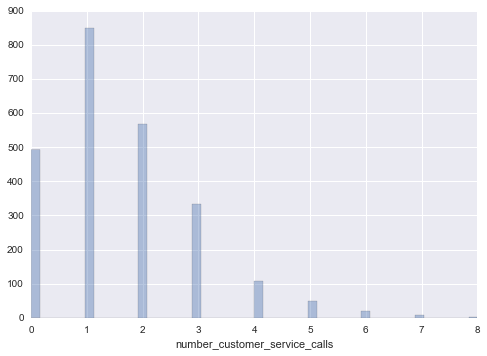

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

sb.distplot(sample_data['number_customer_service_calls'], kde=False)

In [7]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

label_indexer = StringIndexer(inputCol = 'churned', outputCol = 'label')
plan_indexer = StringIndexer(inputCol = 'intl_plan', outputCol = 'intl_plan_indexed')

reduced_numeric_cols = ["account_length", "number_vmail_messages", "total_day_calls", "total_day_charge", "total_eve_calls", "total_eve_charge", "total_night_calls", "total_intl_calls", "total_intl_charge"]

assembler = VectorAssembler( inputCols = ['intl_plan_indexed'] + reduced_numeric_cols, outputCol = 'features')

In [8]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = churn_data.randomSplit([0.7, 0.3])

<font size="5" color="black">ML Pipelines</font> 
<p>A practical <b>ML pipeline</b> often involves a sequence of data pre-processing, feature extraction, model fitting, and validation stages.
A pipeline consists of a sequence of stages. There are two basic types of pipeline stages:  <b> Transformer and Estimator  </b>. 
<li><b>Transformer</b> takes a dataset as input and produces an augmented dataset as output. 
<li><b>Estimator</b> must be first fit on the input dataset to produce a model, which is a Transformer that transforms the input dataset

In [9]:
# Train a RandomForest model.
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
 
classifier = RandomForestClassifier(labelCol = 'label', featuresCol = 'features')
pipeline = Pipeline(stages=[plan_indexer, label_indexer, assembler, classifier])
model = pipeline.fit(trainingData)

In [10]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("prediction", "label", "features").show(50)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|[0.0,41.0,0.0,66....|
|       0.0|  0.0|[0.0,48.0,37.0,11...|
|       0.0|  0.0|[0.0,52.0,0.0,104...|
|       0.0|  0.0|[0.0,59.0,0.0,96....|
|       0.0|  0.0|[0.0,59.0,0.0,104...|
|       0.0|  0.0|[0.0,71.0,0.0,84....|
|       0.0|  0.0|[0.0,74.0,0.0,114...|
|       0.0|  0.0|[0.0,86.0,0.0,85....|
|       0.0|  0.0|[0.0,91.0,0.0,120...|
|       0.0|  0.0|[0.0,98.0,0.0,130...|
|       0.0|  0.0|[0.0,99.0,0.0,96....|
|       0.0|  0.0|[0.0,110.0,0.0,95...|
|       0.0|  0.0|[0.0,112.0,0.0,10...|
|       0.0|  0.0|[0.0,115.0,0.0,12...|
|       0.0|  0.0|[0.0,117.0,0.0,95...|
|       0.0|  0.0|[0.0,120.0,0.0,97...|
|       0.0|  0.0|[0.0,141.0,43.0,1...|
|       0.0|  0.0|[1.0,146.0,0.0,85...|
|       0.0|  0.0|[0.0,12.0,0.0,112...|
|       0.0|  0.0|[1.0,19.0,0.0,98....|
|       1.0|  1.0|[0.0,26.0,0.0,143...|
|       0.0|  0.0|[0.0,41.0,34.0,63...|


<font size="5" color="green">Evaluation vs. Cross Validation</font>
<p>Evaluation and cross validation are standard ways to measure the performance of your model. They both generate evaluation metrics that you can inspect or compare against those of other models.


<b>Evaluate Model</b> expects a scored dataset as input (or 2 in case you would like to compare the performance of 2 different models). This means that you need to train your model using the Train Model module and make predictions on some dataset using the Score Model module, before you can evaluate the results. The evaluation is the based on the scored labels/probabilities along with the true labels, all of which are output by the Score Model module.

In [12]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="precision")

accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))


Test Error = 0.0827943


<b>Cross-Validate </b> expects an untrained model and some labeled dataset and outputs the evaluation results of each of the 10 folds, in addition to the averaged results.

In [13]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
 
predictions = model.transform(testData)
evaluator = BinaryClassificationEvaluator()
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

<b>AUROC (The Area Under an ROC Curve)</b>
<p>When using normalized units, the area under the curve (often referred to as simply the AUC, or AUROC) is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one (assuming 'positive' ranks higher than 'negative').

<b>AUPR (The Area Under an Precision-Recall)</b> 
<p> The area under the precision-recall curve (AUPR) is a single  number  summary  of  the  information  in  the  precision-recall (PR) curve.

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = model.transform(testData)
evaluator = BinaryClassificationEvaluator()
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
"The AUROC is %s and the AUPR is %s." % (auroc, aupr)

'The AUROC is 0.80877604395 and the AUPR is 0.663822809814.'